## Arewa Data Science Academy
### Deep Learning Cohort2.0

#### Name: Umar Faruk Ibrahim
#### Email: ibrahimumarfaruk2000@gmail.com
#### Title: Week 5 Solution.

PyTorch Custom Datasets Exercises Template

Welcome to the PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

In [1]:
# Check for GPU
!nvidia-smi

Tue Apr 22 13:34:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.6.0+cu124


'cuda'

### 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. **Increase Model Complexity**  
   Use a more complex model (e.g., deeper neural networks or more decision tree depth) to better capture the underlying patterns in the data.

2. **Train Longer or Adjust Learning Rate**  
   Allow the model to train for more epochs or fine-tune the learning rate so it has enough time and capacity to learn from the data.

3. **Feature Engineering**  
   Add or transform input features to provide more relevant information, helping the model better understand the data relationships.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/2129685.jpg
Image class: steak
Image height: 512
Image width: 512


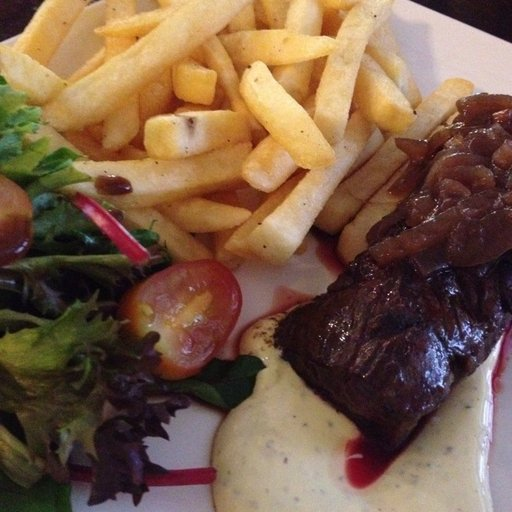

In [6]:
# Visualize an image
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

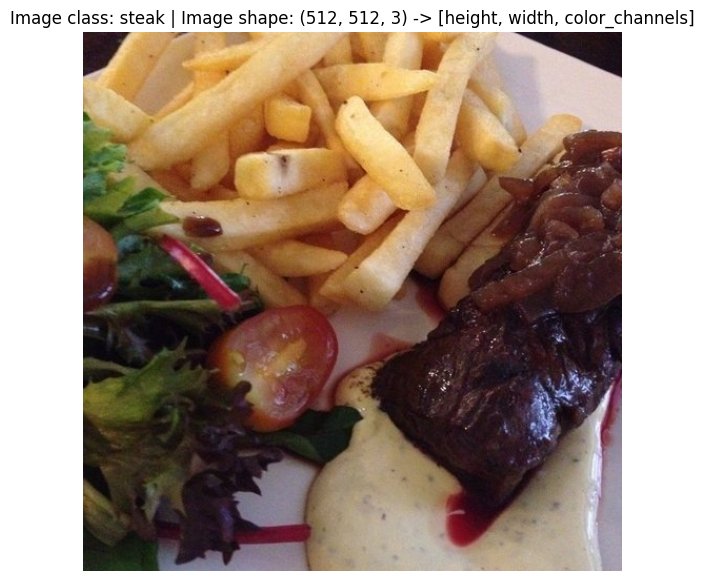

In [7]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [8]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

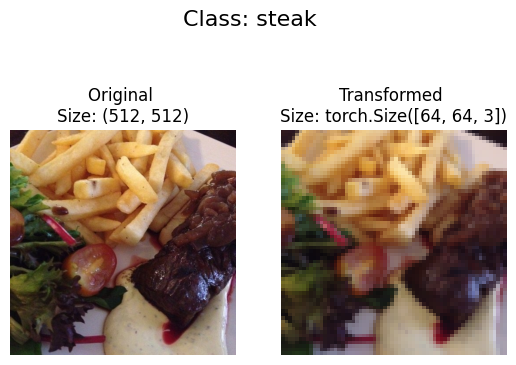

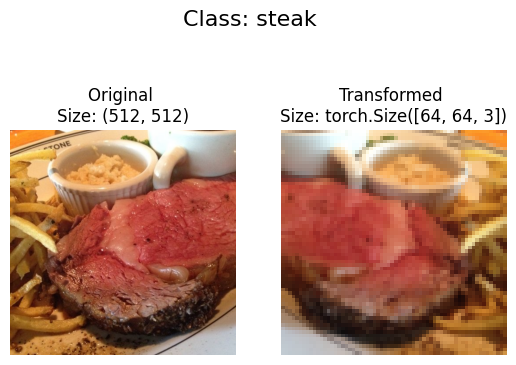

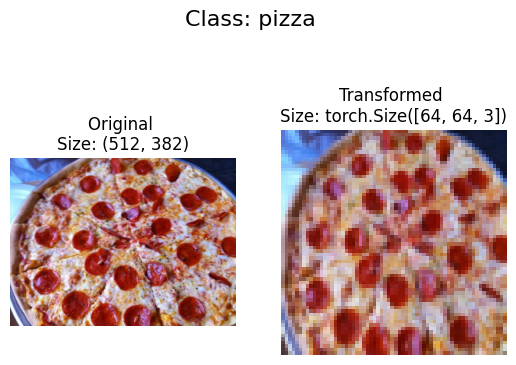

In [10]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

### Load image data using `ImageFolder`

In [11]:
# Use ImageFolder to create dataset(s)
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [15]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data,
                               batch_size=1, # how many samples per batch?
                               num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                               shuffle=True) # shuffle the data?
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7f88b57df490>,
 <torch.utils.data.dataloader.DataLoader at 0x7f88b575f190>)

In [16]:
# How many batches of images are in our data loaders?
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of 1 samples")
print(f"Length of test dataloader: {len(test_dataloader)} batches of 1 samples")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f88b57df490>, <torch.utils.data.dataloader.DataLoader object at 0x7f88b575f190>)
Length of train dataloader: 225 batches of 1 samples
Length of test dataloader: 75 batches of 1 samples


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [17]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [18]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device)
    # 1. Forward pass
    y_pred = model(X)
    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [19]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [20]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [21]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results_5_epochs = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1099 | train_acc: 0.2844 | test_loss: 1.1002 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0997 | train_acc: 0.3289 | test_loss: 1.1006 | test_acc: 0.3333
Epoch: 3 | train_loss: 1.0998 | train_acc: 0.3289 | test_loss: 1.1007 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0999 | train_acc: 0.3156 | test_loss: 1.1005 | test_acc: 0.3333
Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333
Total training time: 8.565 seconds


In [22]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG
model_1 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results_20_epochs = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0984 | train_acc: 0.3022 | test_loss: 1.1010 | test_acc: 0.2133
Epoch: 2 | train_loss: 1.0985 | train_acc: 0.3022 | test_loss: 1.1009 | test_acc: 0.2267
Epoch: 3 | train_loss: 1.0987 | train_acc: 0.3022 | test_loss: 1.1008 | test_acc: 0.2667
Epoch: 4 | train_loss: 1.0985 | train_acc: 0.2889 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.3244 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3289 | test_loss: 1.1007 | test_acc: 0.3067
Epoch: 7 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1008 | test_acc: 0.2800
Epoch: 8 | train_loss: 1.0986 | train_acc: 0.2978 | test_loss: 1.1009 | test_acc: 0.2267
Epoch: 9 | train_loss: 1.0984 | train_acc: 0.3111 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 10 | train_loss: 1.0984 | train_acc: 0.2978 | test_loss: 1.1008 | test_acc: 0.2800
Epoch: 11 | train_loss: 1.0985 | train_acc: 0.3111 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 12 | train_l

In [23]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

# Recreate an instance of TinyVGG
model_2 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Set number of epochs
NUM_EPOCHS = 50

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results_50_epochs = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0984 | train_acc: 0.3022 | test_loss: 1.1010 | test_acc: 0.2133
Epoch: 2 | train_loss: 1.0985 | train_acc: 0.3022 | test_loss: 1.1009 | test_acc: 0.2267
Epoch: 3 | train_loss: 1.0987 | train_acc: 0.3022 | test_loss: 1.1008 | test_acc: 0.2667
Epoch: 4 | train_loss: 1.0985 | train_acc: 0.2889 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 5 | train_loss: 1.0985 | train_acc: 0.3244 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3289 | test_loss: 1.1007 | test_acc: 0.3067
Epoch: 7 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1008 | test_acc: 0.2800
Epoch: 8 | train_loss: 1.0986 | train_acc: 0.2978 | test_loss: 1.1009 | test_acc: 0.2267
Epoch: 9 | train_loss: 1.0984 | train_acc: 0.3111 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 10 | train_loss: 1.0984 | train_acc: 0.2978 | test_loss: 1.1008 | test_acc: 0.2800
Epoch: 11 | train_loss: 1.0985 | train_acc: 0.3111 | test_loss: 1.1009 | test_acc: 0.2400
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [24]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate an instance of TinyVGG
model_3 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results_double_hidden_units = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 2 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 3 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1014 | test_acc: 0.2533
Epoch: 4 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1015 | test_acc: 0.2533
Epoch: 5 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 6 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 7 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 8 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1016 | test_acc: 0.2533
Epoch: 9 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 10 | train_loss: 1.0984 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 11 | train_loss: 1.0985 | train_acc: 0.3333 | test_loss: 1.1017 | test_acc: 0.2533
Epoch: 12 | train_l

In [25]:
import pandas as pd
model_1_df = pd.DataFrame(model_0_results_20_epochs)
model_3_df = pd.DataFrame(model_0_results_double_hidden_units)
model_1_df, model_3_df

(    train_loss  train_acc  test_loss  test_acc
 0     1.098377   0.302222   1.101013  0.213333
 1     1.098514   0.302222   1.100899  0.226667
 2     1.098651   0.302222   1.100800  0.266667
 3     1.098547   0.288889   1.100931  0.240000
 4     1.098482   0.324444   1.100930  0.240000
 5     1.098472   0.328889   1.100675  0.306667
 6     1.098489   0.333333   1.100780  0.280000
 7     1.098564   0.297778   1.100907  0.226667
 8     1.098354   0.311111   1.100905  0.240000
 9     1.098411   0.297778   1.100801  0.280000
 10    1.098496   0.311111   1.100908  0.240000
 11    1.098412   0.302222   1.100826  0.240000
 12    1.098354   0.324444   1.100952  0.213333
 13    1.098448   0.284444   1.100646  0.266667
 14    1.098515   0.275556   1.101095  0.240000
 15    1.098420   0.333333   1.100862  0.266667
 16    1.098548   0.302222   1.100981  0.226667
 17    1.098257   0.337778   1.100677  0.253333
 18    1.098349   0.306667   1.101091  0.200000
 19    1.098488   0.297778   1.100729  0

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?

In [26]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [27]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images...

In [28]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [29]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(root=train_data_20_percent_path,
                                    transform=simple_transform,
                                    target_transform=None)

test_data_20_percent = ImageFolder(root=test_data_20_percent_path,
                                   transform=simple_transform,
                                   target_transform=None)

# Create dataloaders
train_dataloader_20_percent = DataLoader(dataset=train_data_20_percent,
                                         batch_size=1,
                                         num_workers=1,
                                         shuffle=True)
test_dataloader_20_percent = DataLoader(dataset=test_data_20_percent,
                                        batch_size=1,
                                        num_workers=1,
                                        shuffle=False)

In [30]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),
                             lr=0.001)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results_double_data = train(model=model_3,
                        train_dataloader=train_dataloader_20_percent,
                        test_dataloader=test_dataloader_20_percent,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 2 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 3 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 5 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 6 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 7 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 8 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 9 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 11 | train_loss: 1.0988 | train_acc: 0.3244 | test_loss: 1.0969 | test_acc: 0.3867
Epoch: 12 | train_l

In [31]:
import pandas as pd
model_3A_df = pd.DataFrame(model_0_results_double_hidden_units)
model_3B_df = pd.DataFrame(model_0_results_double_data)
model_3A_df, model_3B_df

(    train_loss  train_acc  test_loss  test_acc
 0     1.098430   0.333333   1.101654  0.253333
 1     1.098431   0.333333   1.101690  0.253333
 2     1.098370   0.333333   1.101434  0.253333
 3     1.098413   0.333333   1.101532  0.253333
 4     1.098434   0.333333   1.101687  0.253333
 5     1.098462   0.333333   1.101714  0.253333
 6     1.098401   0.333333   1.101593  0.253333
 7     1.098429   0.333333   1.101639  0.253333
 8     1.098408   0.333333   1.101683  0.253333
 9     1.098374   0.333333   1.101653  0.253333
 10    1.098454   0.333333   1.101709  0.253333
 11    1.098439   0.333333   1.101625  0.253333
 12    1.098454   0.333333   1.101528  0.253333
 13    1.098410   0.333333   1.101460  0.253333
 14    1.098446   0.333333   1.101746  0.253333
 15    1.098407   0.333333   1.101624  0.253333
 16    1.098439   0.333333   1.101535  0.253333
 17    1.098433   0.333333   1.101500  0.253333
 18    1.098446   0.333333   1.101604  0.253333
 19    1.098436   0.333333   1.101624  0

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [33]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [35]:
# prompt: Make a prediction on your own custom image of pizza/steak/sushi (the one we downloaded and set the dataloader) with your trained model from exercise 7 and share your prediction.

import torchvision
from PIL import Image

# Load your custom image
custom_image_path = "/content/data/04-pizza-dad.jpeg" # Replace with your image path
img = Image.open(custom_image_path)

# Preprocess the image (same transformations as your training data)
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
img_transformed = image_transform(img)
img_transformed = img_transformed.unsqueeze(0).to(device) # Add batch dimension and send to device

# Make a prediction
model_2.eval()  # Put the model in evaluation mode
with torch.no_grad():  # No need to calculate gradients
    pred_probs = torch.softmax(model_3(img_transformed), dim=1)

# Get the predicted class
pred_label = torch.argmax(pred_probs, dim=1)

# Print the prediction
print(f"Predicted class: {class_names[pred_label.item()]}")


Predicted class: steak
